# Continuity Equation



We look to solve the continuity equation for a given flow for a one dimensional flow.

$$ \frac{\partial \rho}{\partial t} + \frac{\partial}{\partial x}\left(\rho u\right) = 0$$

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Parameters
L = 1.0         # Length of the domain
T = 1.0         # Total simulation time
Nx = 200        # Number of spatial points
Nt = 800        # Number of time steps
dx = L / (Nx - 1)
dt = T / Nt

In [3]:
# Initial conditions
x = np.linspace(0, L, Nx)
u = 0.8*np.ones(Nx) #np.exp(-(x - 0.5*L)**2 / 0.1)             # Velocity
rho = np.exp(-(x-0.1*L)**2 /0.001)

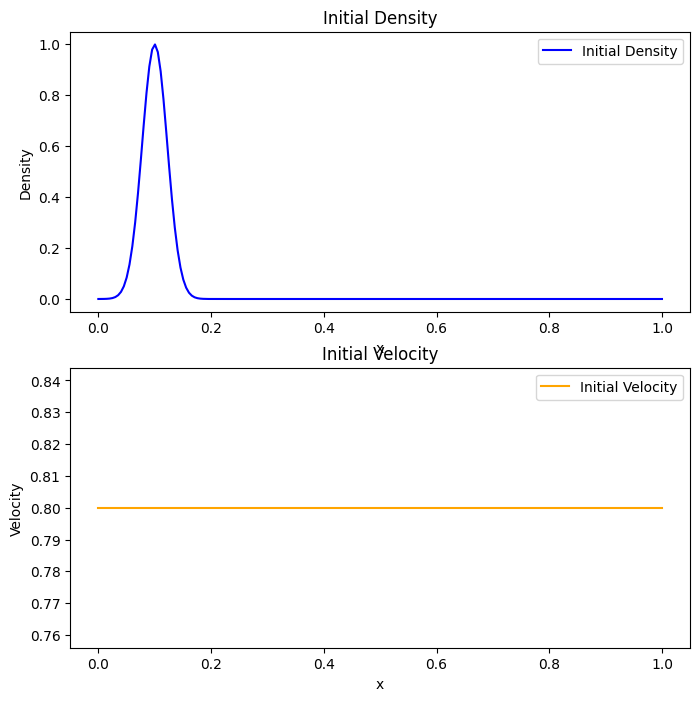

In [4]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
axs[0].plot(x, rho, label='Initial Density', color='blue')
axs[0].set_title('Initial Density')
axs[0].set_xlabel('x')
axs[0].set_ylabel('Density')
axs[0].legend()

axs[1].plot(x, u, label='Initial Velocity', color='orange')
axs[1].set_title('Initial Velocity')
axs[1].set_xlabel('x')
axs[1].set_ylabel('Velocity')
axs[1].legend()

### FCT Algorithm

In [5]:
eps = np.zeros(Nx-1)
eps[:] = (u[1:] + u[:-1]) * dt / (2*dx)
nu = 0.5 * np.abs(eps) 

In [6]:
# Generate Matrix
import scipy.sparse as sp
d_1 = np.zeros(Nx-1)
d_2 = np.zeros(Nx-1)
d_p = np.ones(Nx)
d_1[1:] = nu[1:] - 0.5*eps[1:]
d_2[:-1] = nu[:-1] + 0.5*eps[:-1]
d_p[1:-1] = 1 - 0.5*(eps[1:] - eps[:-1]) - nu[:-1] - nu[1:]
M = sp.diags([d_2, d_p, d_1], offsets=[-1, 0, 1], shape = (Nx,Nx), format='csr')

In [7]:
rho_tilde = np.zeros(Nx)
mu = nu - 0.5*np.abs(eps)
solution = np.zeros((rho.shape[0], Nt+1))
solution[:, 0] = rho[:]

for i in range(1, Nt+1):
    rho_tilde = M@solution[:,i-1]
    f_ad = mu*(rho_tilde[1:] - rho_tilde[:-1])
    s = np.sign(rho_tilde[1:] - rho_tilde[:-1])
    aux = np.zeros(Nx-1)
    aux[:-1] = (rho_tilde[2:] - rho_tilde[1:-1])
    f_cor = s * np.maximum(0, np.minimum(s*aux, np.abs(f_ad), s*(rho_tilde[1:] - rho_tilde[:-1])))
    solution[1:-1, i] = rho_tilde[1:-1] - f_cor[1:] + f_cor[:-1]

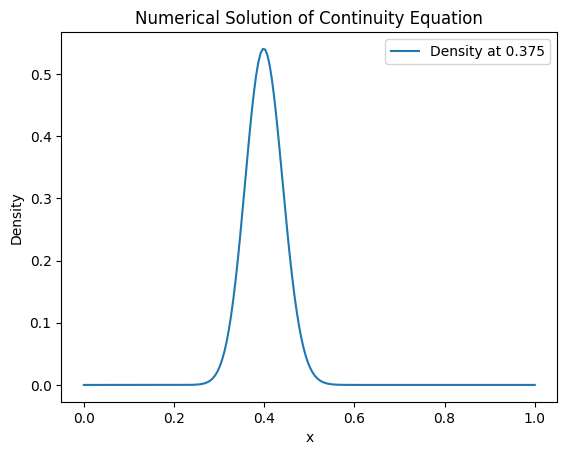

In [8]:
idx = 300
plt.plot(x, solution[:,idx], label=f'Density at {T * idx/Nt}')
plt.title('Numerical Solution of Continuity Equation')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()

### Lax-Wendroff

In [12]:
rho_sol = np.zeros((Nx, Nt+1))
rho_sol[:,0] = rho
diff_f = np.zeros(Nx)
u_mean = 0.5*(u[1:] + u[:-1])

for i in range(1, Nt+1):
    f = u*rho_sol[:,i-1]

    rho_prov = 0.5*(rho_sol[1:,i-1] + rho_sol[:-1,i-1]) - 0.5*dt*(f[1:] - f[:-1])/dx
    f_prov =  u_mean * rho_prov
    diff_f[1:-1] = f_prov[1:] - f_prov[:-1]
    rho_sol[:,i] = rho_sol[:,i-1] - dt * (diff_f)/dx

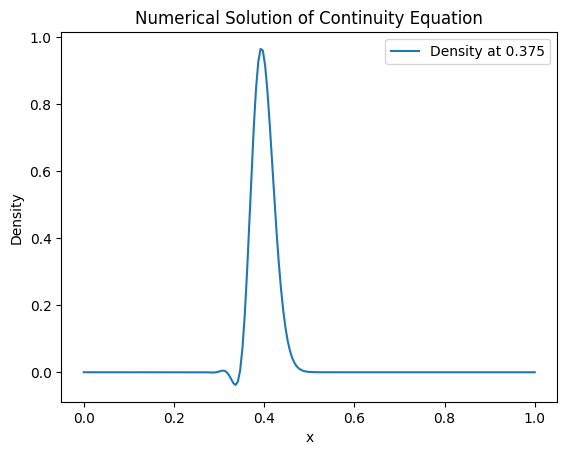

In [13]:
idx = 300
plt.plot(x, rho_sol[:,idx], label=f'Density at {T * idx/Nt}')
plt.title('Numerical Solution of Continuity Equation')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()

## Periodic boundary conditions

In [17]:
# Initial conditions
x = np.linspace(0, L, Nx)
u = 2*np.ones(Nx) #np.exp(-(x - 0.5*L)**2 / 0.1)             # Velocity
rho = np.zeros(Nx)       # Example initial density profile
rho[:Nx//2] = 0
rho[Nx//2:] = 1

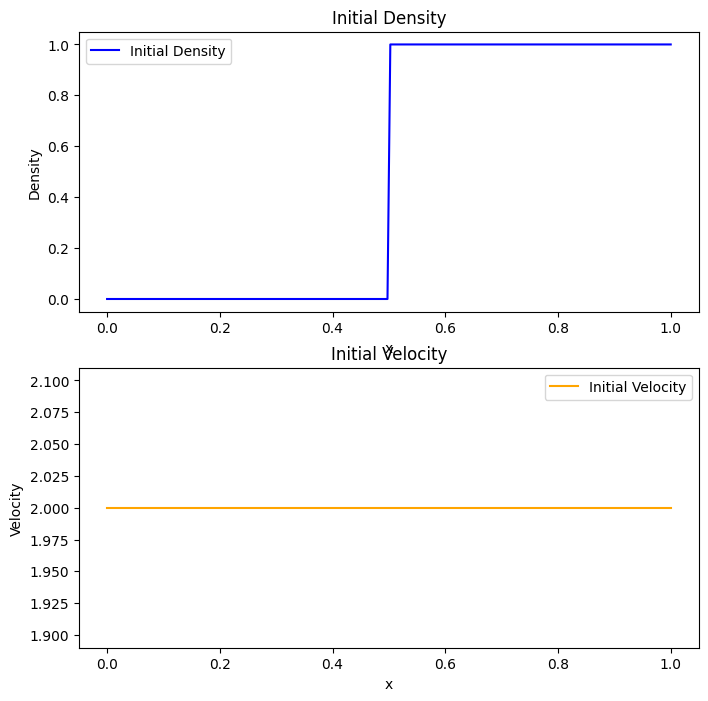

In [18]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
axs[0].plot(x, rho, label='Initial Density', color='blue')
axs[0].set_title('Initial Density')
axs[0].set_xlabel('x')
axs[0].set_ylabel('Density')
axs[0].legend()

axs[1].plot(x, u, label='Initial Velocity', color='orange')
axs[1].set_title('Initial Velocity')
axs[1].set_xlabel('x')
axs[1].set_ylabel('Velocity')
axs[1].legend()

### Lax-Wendroff

In [21]:
rho_sol = np.zeros((Nx, Nt+1))
rho_sol[:,0] = rho
diff_f = np.zeros(Nx)
rho_prov = np.zeros(Nx)
u_mean = np.zeros(Nx)
u_mean[:-1] = 0.5*(u[1:] + u[:-1])
u_mean[-1] = 0.5*(u[0] + u[-1])

for i in range(1, Nt+1):
    f = u*rho_sol[:,i-1]
    rho_prov[:-1] = 0.5*(rho_sol[1:,i-1] + rho_sol[:-1,i-1]) - 0.5*dt*(f[1:] - f[:-1])/dx
    rho_prov[-1] = 0.5*(rho_sol[0,i-1] + rho_sol[-1,i-1]) - 0.5*dt*(f[0] - f[-1])/dx
    f_prov =  u_mean * rho_prov
    diff_f[:-1] = f_prov[1:] - f_prov[:-1]
    diff_f[-1] = f_prov[0] - f_prov[-1]
    rho_sol[:,i] = rho_sol[:,i-1] - dt * (diff_f)/dx
    #rho_sol[0,i] = rho_sol[-1,i] 

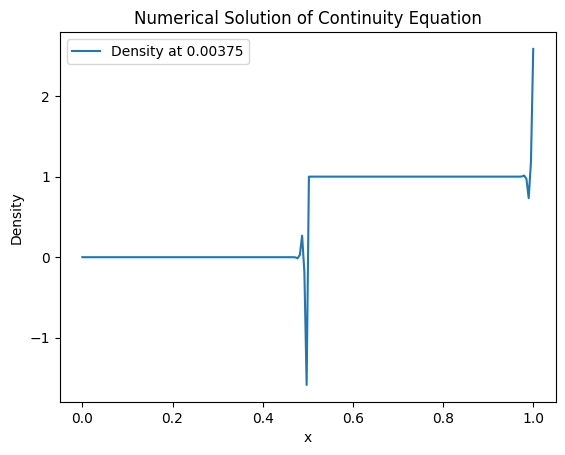

In [23]:
idx = 3
plt.plot(x, rho_sol[:,idx], label=f'Density at {T * idx/Nt}')
plt.title('Numerical Solution of Continuity Equation')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()

### FCT Algorithm

In [19]:
eps = np.zeros(Nx)
eps[:-1] = (u[1:] + u[:-1]) * dt / (2*dx)
eps[-1] = (u[0] + u[-1]) * dt / (2*dx)
nu = 0.5 * np.abs(eps) + 0.15

In [20]:
# Generate Matrix
d_1 = np.zeros(Nx-1)
d_2 = np.zeros(Nx-1)
d_p = np.ones(Nx)
d_1[:] = nu[:-1] - 0.5*eps[:-1]
d_2[:] = nu[1:] + 0.5*eps[1:]
d_p[:-1] = 1 - 0.5*(eps[1:] - eps[:-1]) - nu[:-1] - nu[1:]
d_p[-1] = 1 - 0.5*(eps[0] - eps[-1]) - nu[-1] - nu[0]
d_b1 = nu[-1] - 0.5*eps[-1]
d_b2 = nu[0] + 0.5*eps[0]
M = sp.diags([d_b1, d_2, d_p, d_1, d_b2], offsets=[-Nx+1, -1, 0, 1, Nx-1], shape = (Nx,Nx), format='csr')

In [21]:
rho_tilde = np.zeros(Nx)
f_ad = np.zeros(Nx)
f_cor = np.zeros(Nx)
s = np.zeros(Nx)
aux = np.zeros(Nx)
difff = np.zeros(Nx)
mu = nu - 0.5*np.abs(eps)
solution = np.zeros((rho.shape[0], Nt+1))
solution[:, 0] = rho

for i in range(1, Nt+1):
    rho_tilde = M@solution[:,i-1]
    f_ad[:-1] = mu[:-1]*(rho_tilde[1:] - rho_tilde[:-1])
    f_ad[-1] = mu[-1]*(rho_tilde[0] - rho_tilde[-1])
    s[:-1] = np.sign(rho_tilde[1:] - rho_tilde[:-1])
    s[-1] = np.sign(rho_tilde[0] - rho_tilde[-1])
    aux[:-2] = (rho_tilde[2:] - rho_tilde[1:-1])
    aux[-2] = (rho_tilde[0] - rho_tilde[-1])
    aux[-1] = (rho_tilde[1] - rho_tilde[0])
    difff[:-1] = (rho_tilde[1:] - rho_tilde[:-1])
    difff[-1] = (rho_tilde[0] - rho_tilde[-1])
    f_cor = s * np.maximum(0, np.minimum(s*aux, np.abs(f_ad), s*difff))
    
    solution[:-1, i] = rho_tilde[:-1] - f_cor[1:] + f_cor[:-1]
    solution[-1, i] = rho_tilde[-1] - f_cor[0] + f_cor[-1]

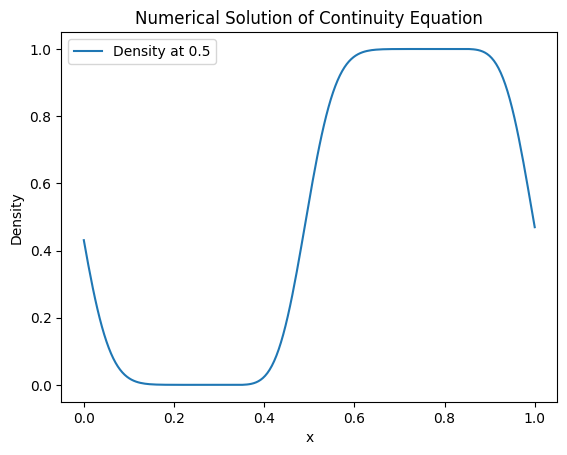

In [22]:
idx = 400
plt.plot(x, solution[:,idx], label=f'Density at {T * idx/Nt}')
plt.title('Numerical Solution of Continuity Equation')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()

## Animations

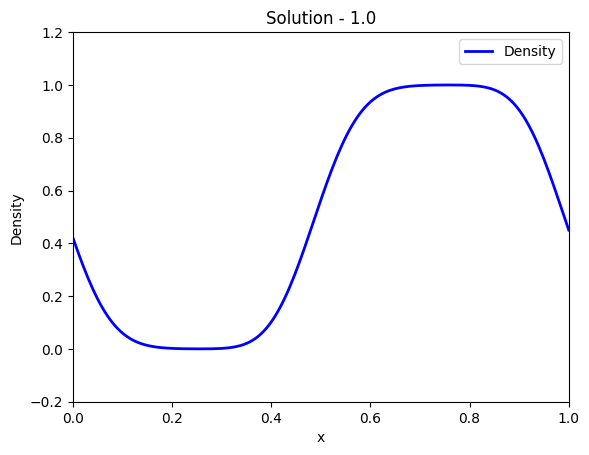

In [23]:
import matplotlib.animation as animation
# Initialize plot
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2, color='blue', label='Density')
ax.legend()
ax.set_xlim(0, 1)
ax.set_ylim(-0.2, 1.2)
ax.set_xlabel('x')
ax.set_ylabel('Density')

# Function to initialize plot
def init():
    line.set_data([], [])
    return line,

# Function to animate plot
def animate(i):
    y = solution[:,i]
    line.set_data(x, y)
    ax.set_title(f"Solution - {i*dt}") # Update title with file name
    return line,

# Create animation
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=Nt+1, interval=200, blit=True)

# Save animation as a gif (optional)
ani.save('animations/C/density_periodic.gif', writer='pillow', fps=24)

# Show plot
plt.show()